In [86]:
import gzip
from tqdm import tqdm

In [87]:
## if running on colab uncomment this
# from google.colab import drive
# drive.mount('/content/drive')

# %cd "/content/drive/MyDrive/Kuliah/DM/project"

In [88]:
with gzip.open('wikidata5m_all_triplet.txt.gz', 'rb') as f:
  file_content = f.read()

In [89]:
def process_to_list_of_triplets(content):
  triples = content.split('\r\n')
  triples = [tuple(triple.split('\t')) for triple in triples]
  return triples

In [90]:
list_of_triples = process_to_list_of_triplets(file_content.decode("utf-8"))

In [91]:
len(list_of_triples)

21354360

In [92]:
def process_list_of_triples_to_dict(triples):
  result = {}
  for triple in tqdm(triples):
    result[(triple[0], triple[-1])] = triple[1]
  return result

In [93]:
list_of_triples[-2]

('Q2485452', 'P31', 'Q34442')

In [94]:
# exclude the last one, not a triple
triples_dict = process_list_of_triples_to_dict(list_of_triples[:-1])

100%|██████████| 21354359/21354359 [00:59<00:00, 360873.88it/s]


In [95]:
# get degree
def get_degree(triples):
    out_degree_dict = {}
    in_degree_dict = {}
    for triple in tqdm(triples):
        out_degree_dict[triple[0]] = out_degree_dict.get(triple[0], 0) + 1
        in_degree_dict[triple[2]] = in_degree_dict.get(triple[2], 0) + 1
    return out_degree_dict, in_degree_dict

out_dict, in_dict = get_degree(list_of_triples[:-1])

100%|██████████| 21354359/21354359 [00:25<00:00, 834542.74it/s]


In [96]:
out_dict_sorted = dict(sorted(out_dict.items(), key=lambda item: item[1], reverse=True))
in_dict_sorted = dict(sorted(in_dict.items(), key=lambda item: item[1], reverse=True))

print(list(out_dict_sorted.items())[:5])
print(list(in_dict_sorted.items())[:5])

[('Q623', 1368), ('Q12652', 873), ('Q3093', 833), ('Q979470', 692), ('Q2900529', 690)]
[('Q5', 1530721), ('Q30', 817687), ('Q16521', 364147), ('Q7432', 286633), ('Q145', 265383)]


In [97]:
out_dict_sorted

{'Q623': 1368,
 'Q12652': 873,
 'Q3093': 833,
 'Q979470': 692,
 'Q2900529': 690,
 'Q1270623': 689,
 'Q12626': 581,
 'Q12538': 557,
 'Q3105': 555,
 'Q3249': 547,
 'Q12717': 546,
 'Q12589': 533,
 'Q12700': 532,
 'Q12736': 521,
 'Q12753': 520,
 'Q12703': 520,
 'Q3361': 519,
 'Q3372': 518,
 'Q3357': 518,
 'Q12679': 516,
 'Q12722': 515,
 'Q40030': 508,
 'Q2150573': 504,
 'Q12816': 471,
 'Q707051': 456,
 'Q12607': 450,
 'Q707063': 439,
 'Q3083': 433,
 'Q670933': 432,
 'Q23558762': 425,
 'Q40430': 412,
 'Q15499': 409,
 'Q463606': 406,
 'Q314532': 395,
 'Q159': 393,
 'Q30': 383,
 'Q12549': 372,
 'Q1999970': 360,
 'Q12545': 353,
 'Q12569': 345,
 'Q3113': 337,
 'Q451110': 330,
 'Q16287': 329,
 'Q408': 314,
 'Q46130': 308,
 'Q183': 305,
 'Q41115': 295,
 'Q36687': 291,
 'Q1030713': 291,
 'Q148': 279,
 'Q3353': 277,
 'Q12820': 276,
 'Q28003': 273,
 'Q12174': 266,
 'Q865': 265,
 'Q15091': 260,
 'Q16137': 257,
 'Q142': 255,
 'Q41587': 251,
 'Q38': 242,
 'Q649': 242,
 'Q8613': 238,
 'Q3068': 238,
 'Q3

In [98]:
import requests  
from bs4 import BeautifulSoup

def get_name(code):
    if code[0] == 'P':
        url = f"https://www.wikidata.org/wiki/Property:{code}"
    else:
        url = f"https://www.wikidata.org/wiki/{code}"
    
    html = requests.get(url).content
    soup = BeautifulSoup(html, 'html.parser')
    
    title = soup.find_all('span', {'class': 'wikibase-title-label'})
    return title[0].get_text()

get_name("Q1794")

'Frankfurt'

In [99]:
from collections import deque
from tqdm import tqdm
import random

def get_subgraph_bottom_up(max_depth: int, start_node: str, triples_list: list, sampling_ratio: float, seed: int, debug: bool = True):
    triples = []
    # adjust the max_depth
    max_depth -= 1
    # tuple of start_node and depth
    queue = deque([(start_node, 0)])
    random.seed(seed)    
    if debug:
        curr_depth_debug = 0
        print(f"Currently on depth {curr_depth_debug}")
        print(f"Inspecting {len(queue)} child")
        while queue:
            curr_node, curr_depth = queue.popleft()
            if curr_depth != curr_depth_debug:
                curr_depth_debug = curr_depth
                print(f"Currently on depth {curr_depth_debug}")
                print(f"Inspecting {len(queue) + 1} children, sampled by {sampling_ratio}")
            # get adjacent node
            triple_neighbors = [triple for triple in triples_list if triple[-1] == curr_node]
            
            if(curr_depth != 0):
                print("triple_neighbors", triple_neighbors)
                
            if curr_depth < max_depth:
                # continue doing BFS (continue adding to queue)
                temp_queue = deque([])
                for neighbor in tqdm(triple_neighbors):
                    # however, only several neighbors will continue the BFS iteration
                    temp_queue.append((neighbor[0], curr_depth + 1))
                # sampling
                num_to_sample = min(int(len(temp_queue)), 125)
                sampled_elements = random.sample(temp_queue, num_to_sample)
                triples.extend(sampled_elements)
                queue.extend(sampled_elements)
            else:
                # stop doing BFS (stop adding to queue)
                # sampling again for the last depth
                temp_list = []
                for neighbor in tqdm(triple_neighbors):
                    temp_list.append(neighbor)
                num_to_sample = min(int(len(temp_list)), 125)
                sampled_elements = random.sample(temp_list, num_to_sample)
                triples.extend(sampled_elements)
    else:
        while queue:
            curr_node, curr_depth = queue.popleft()
            # get adjacent node
            triple_neighbors = [triple for triple in triples_list if triple[2] == curr_node]
            if curr_depth < max_depth:
                # continue doing BFS (continue adding to queue)
                temp_queue = deque([])
                for neighbor in triple_neighbors:
                    triples.append(neighbor)
                    temp_queue.append((neighbor[0], curr_depth + 1))
                # sampling
                num_to_sample = min(int(len(temp_list)), 125)
                sampled_elements = random.sample(temp_queue, num_to_sample)
                queue.extend(sampled_elements)
            else:
                # stop doing BFS (stop adding to queue)
                temp_list = []
                for neighbor in triple_neighbors:
                    temp_list.append(neighbor) 
                num_to_sample = min(int(len(temp_list)), 125)
                sampled_elements = random.sample(temp_list, num_to_sample)
                triples.extend(sampled_elements)
    
    return triples


In [100]:
triples = get_subgraph_bottom_up(3, 'Q5', list_of_triples, 0.05, 19)

Currently on depth 0
Inspecting 1 child


100%|██████████| 1530721/1530721 [00:02<00:00, 528452.31it/s] 


Currently on depth 1
Inspecting 125 children, sampled by 0.05
triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q616033', 'P1066', 'Q3169279')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q386210', 'P161', 'Q256102')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q28968345', 'P161', 'Q9332903')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q21480365', 'P57', 'Q4756738'), ('Q1411365', 'P57', 'Q4756738'), ('Q14949764', 'P57', 'Q4756738')]


100%|██████████| 3/3 [00:00<?, ?it/s]


triple_neighbors [('Q7167279', 'P3373', 'Q4798275')]


100%|██████████| 1/1 [00:00<00:00, 703.74it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q759462', 'P161', 'Q272412'), ('Q239794', 'P161', 'Q272412'), ('Q126281', 'P161', 'Q272412'), ('Q1211330', 'P161', 'Q272412'), ('Q20487097', 'P26', 'Q272412'), ('Q4753356', 'P161', 'Q272412'), ('Q1420108', 'P161', 'Q272412'), ('Q3549386', 'P161', 'Q272412'), ('Q2446268', 'P161', 'Q272412'), ('Q1218481', 'P161', 'Q272412'), ('Q725552', 'P161', 'Q272412'), ('Q1030713', 'P161', 'Q272412'), ('Q35791', 'P161', 'Q272412'), ('Q1064885', 'P161', 'Q272412'), ('Q695209', 'P161', 'Q272412'), ('Q1630422', 'P161', 'Q272412'), ('Q1657967', 'P161', 'Q272412'), ('Q380848', 'P161', 'Q272412'), ('Q916835', 'P161', 'Q272412'), ('Q428489', 'P161', 'Q272412'), ('Q2166866', 'P161', 'Q272412'), ('Q656910', 'P161', 'Q272412'), ('Q691838', 'P161', 'Q272412'), ('Q1306730', 'P161', 'Q272412'), ('Q2927264', 'P161', 'Q272412')]


100%|██████████| 25/25 [00:00<?, ?it/s]


triple_neighbors [('Q5189702', 'P112', 'Q6793163')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q910349', 'P527', 'Q2375630')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q25096888', 'P175', 'Q18637966'), ('Q18755896', 'P175', 'Q18637966'), ('Q18785325', 'P175', 'Q18637966'), ('Q18785310', 'P175', 'Q18637966'), ('Q17332396', 'P86', 'Q18637966'), ('Q18785322', 'P175', 'Q18637966')]


100%|██████████| 6/6 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q16467345', 'P710', 'Q1499347')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q3175905', 'P40', 'Q1274954'), ('Q615867', 'P527', 'Q1274954'), ('Q1773542', 'P86', 'Q1274954')]


100%|██████████| 3/3 [00:00<?, ?it/s]


triple_neighbors [('Q502538', 'P527', 'Q3580255')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q992496', 'P161', 'Q7146747')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q434760', 'P26', 'Q1445064'), ('Q2616032', 'P40', 'Q1445064'), ('Q497904', 'P3373', 'Q1445064'), ('Q2280915', 'P3373', 'Q1445064'), ('Q496569', 'P3373', 'Q1445064'), ('Q2555139', 'P25', 'Q1445064'), ('Q21106003', 'P3373', 'Q1445064'), ('Q2919957', 'P3373', 'Q1445064'), ('Q269085', 'P3373', 'Q1445064'), ('Q297194', 'P25', 'Q1445064'), ('Q238341', 'P3373', 'Q1445064'), ('Q41514', 'P40', 'Q1445064')]


100%|██████████| 12/12 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q17101440', 'P22', 'Q1174087'), ('Q4201328', 'P1066', 'Q1174087')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q768476', 'P1346', 'Q3848016'), ('Q1753416', 'P162', 'Q3848016'), ('Q3828934', 'P162', 'Q3848016'), ('Q3516516', 'P161', 'Q3848016'), ('Q2656720', 'P162', 'Q3848016'), ('Q387468', 'P162', 'Q3848016'), ('Q1632051', 'P162', 'Q3848016'), ('Q1299410', 'P162', 'Q3848016'), ('Q810703', 'P162', 'Q3848016'), ('Q1195580', 'P58', 'Q3848016')]


100%|██████████| 10/10 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q280411', 'P3373', 'Q6262765')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q2456013', 'P161', 'Q3134231')]


100%|██████████| 1/1 [00:00<00:00, 968.44it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q151973', 'P26', 'Q3469983')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q5284525', 'P138', 'Q634776'), ('Q7141839', 'P138', 'Q634776'), ('Q14935141', 'P138', 'Q634776')]


100%|██████████| 3/3 [00:00<?, ?it/s]


triple_neighbors [('Q7309726', 'P175', 'Q703330'), ('Q5033542', 'P175', 'Q703330'), ('Q6496321', 'P1346', 'Q703330'), ('Q6697403', 'P26', 'Q703330')]


100%|██████████| 4/4 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q2586522', 'P3373', 'Q2825676'), ('Q1945530', 'P138', 'Q2825676')]


100%|██████████| 2/2 [00:00<00:00, 2989.53it/s]


triple_neighbors [('Q2870390', 'P161', 'Q435347'), ('Q2394537', 'P161', 'Q435347')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q22083405', 'P527', 'Q17505105')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q712690', 'P40', 'Q6399403'), ('Q293679', 'P3373', 'Q6399403'), ('Q1441910', 'P3373', 'Q6399403'), ('Q4665226', 'P3373', 'Q6399403'), ('Q7855214', 'P3373', 'Q6399403')]


100%|██████████| 5/5 [00:00<?, ?it/s]

Currently on depth 2
Inspecting 90 children, sampled by 0.05


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q1753343', 'P1889', 'Q2166866')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q3729836', 'P361', 'Q35791'), ('Q254678', 'P1441', 'Q35791'), ('Q3729842', 'P361', 'Q35791'), ('Q381751', 'P155', 'Q35791'), ('Q900477', 'P1441', 'Q35791'), ('Q937126', 'P1441', 'Q35791'), ('Q860320', 'P1441', 'Q35791')]


100%|██████████| 7/7 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q7710996', 'P156', 'Q4753356'), ('Q7487532', 'P155', 'Q4753356')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q16917980', 'P155', 'Q1064885')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q3208352', 'P156', 'Q3549386'), ('Q2495794', 'P155', 'Q3549386')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q7295698', 'P69', 'Q5189702'), ('Q464900', 'P69', 'Q5189702'), ('Q6986984', 'P69', 'Q5189702'), ('Q665105', 'P355', 'Q5189702'), ('Q27949758', 'P69', 'Q5189702'), ('Q6919169', 'P69', 'Q5189702'), ('Q22958146', 'P69', 'Q5189702')]


100%|██████████| 7/7 [00:00<00:00, 4638.25it/s]


triple_neighbors [('Q2375630', 'P463', 'Q910349')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q18637966', 'P358', 'Q18755896')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q21406228', 'P155', 'Q16467345')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors [('Q1274954', 'P25', 'Q3175905')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q3259249', 'P175', 'Q615867'), ('Q16666367', 'P175', 'Q615867'), ('Q213942', 'P710', 'Q615867'), ('Q3548007', 'P175', 'Q615867'), ('Q2751538', 'P175', 'Q615867')]


100%|██████████| 5/5 [00:00<?, ?it/s]


triple_neighbors [('Q847466', 'P155', 'Q502538'), ('Q958593', 'P156', 'Q502538')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q1445064', 'P3373', 'Q269085'), ('Q496569', 'P3373', 'Q269085'), ('Q3486450', 'P22', 'Q269085'), ('Q2919957', 'P3373', 'Q269085'), ('Q21106003', 'P3373', 'Q269085'), ('Q497573', 'P22', 'Q269085'), ('Q497246', 'P22', 'Q269085'), ('Q497904', 'P3373', 'Q269085'), ('Q41514', 'P40', 'Q269085'), ('Q238341', 'P3373', 'Q269085'), ('Q2280915', 'P3373', 'Q269085'), ('Q2616032', 'P40', 'Q269085')]


100%|██████████| 12/12 [00:00<00:00, 12006.60it/s]


triple_neighbors [('Q324085', 'P22', 'Q297194'), ('Q157799', 'P22', 'Q297194'), ('Q231755', 'P22', 'Q297194'), ('Q21748955', 'P138', 'Q297194'), ('Q2555139', 'P3373', 'Q297194'), ('Q1445064', 'P40', 'Q297194'), ('Q287563', 'P22', 'Q297194'), ('Q2026887', 'P26', 'Q297194'), ('Q359596', 'P22', 'Q297194'), ('Q1014431', 'P88', 'Q297194'), ('Q434760', 'P40', 'Q297194')]


100%|██████████| 11/11 [00:00<00:00, 14716.86it/s]


triple_neighbors [('Q21106003', 'P25', 'Q2616032'), ('Q2280915', 'P25', 'Q2616032'), ('Q269085', 'P25', 'Q2616032'), ('Q262305', 'P3373', 'Q2616032'), ('Q1445064', 'P25', 'Q2616032'), ('Q4958322', 'P3373', 'Q2616032'), ('Q238341', 'P25', 'Q2616032'), ('Q375309', 'P40', 'Q2616032'), ('Q41514', 'P26', 'Q2616032'), ('Q3112191', 'P40', 'Q2616032'), ('Q497904', 'P26', 'Q2616032'), ('Q2919957', 'P25', 'Q2616032')]


100%|██████████| 12/12 [00:00<?, ?it/s]


triple_neighbors [('Q2919957', 'P3373', 'Q496569'), ('Q269085', 'P3373', 'Q496569'), ('Q2280915', 'P3373', 'Q496569'), ('Q497904', 'P3373', 'Q496569'), ('Q238341', 'P3373', 'Q496569'), ('Q41514', 'P40', 'Q496569'), ('Q1445064', 'P3373', 'Q496569')]


100%|██████████| 7/7 [00:00<?, ?it/s]


triple_neighbors [('Q365085', 'P26', 'Q2919957'), ('Q2280915', 'P3373', 'Q2919957'), ('Q238341', 'P3373', 'Q2919957'), ('Q2616032', 'P40', 'Q2919957'), ('Q41514', 'P40', 'Q2919957'), ('Q642075', 'P25', 'Q2919957'), ('Q1445064', 'P3373', 'Q2919957'), ('Q313005', 'P26', 'Q2919957'), ('Q21106003', 'P3373', 'Q2919957'), ('Q269085', 'P3373', 'Q2919957'), ('Q496569', 'P3373', 'Q2919957'), ('Q497904', 'P3373', 'Q2919957')]


100%|██████████| 12/12 [00:00<?, ?it/s]


triple_neighbors [('Q434760', 'P40', 'Q2555139'), ('Q297194', 'P3373', 'Q2555139'), ('Q343101', 'P26', 'Q2555139'), ('Q1445064', 'P40', 'Q2555139')]


100%|██████████| 4/4 [00:00<?, ?it/s]


triple_neighbors [('Q496569', 'P3373', 'Q2280915'), ('Q2616032', 'P40', 'Q2280915'), ('Q2465089', 'P22', 'Q2280915'), ('Q497904', 'P3373', 'Q2280915'), ('Q269085', 'P3373', 'Q2280915'), ('Q1445064', 'P3373', 'Q2280915'), ('Q2919957', 'P3373', 'Q2280915'), ('Q41514', 'P40', 'Q2280915'), ('Q238341', 'P3373', 'Q2280915'), ('Q21106003', 'P3373', 'Q2280915')]


100%|██████████| 10/10 [00:00<00:00, 8383.58it/s]


triple_neighbors [('Q1445064', 'P3373', 'Q497904'), ('Q2280915', 'P3373', 'Q497904'), ('Q4305604', 'P22', 'Q497904'), ('Q269085', 'P3373', 'Q497904'), ('Q41514', 'P40', 'Q497904'), ('Q550638', 'P22', 'Q497904'), ('Q2616032', 'P40', 'Q497904'), ('Q717911', 'P22', 'Q497904'), ('Q238341', 'P3373', 'Q497904'), ('Q496569', 'P3373', 'Q497904'), ('Q496545', 'P22', 'Q497904'), ('Q21106003', 'P3373', 'Q497904'), ('Q2919957', 'P3373', 'Q497904'), ('Q2065996', 'P138', 'Q497904')]


100%|██████████| 14/14 [00:00<?, ?it/s]


triple_neighbors [('Q2919957', 'P22', 'Q41514'), ('Q2616032', 'P26', 'Q41514'), ('Q469742', 'P3373', 'Q41514'), ('Q21106003', 'P22', 'Q41514'), ('Q496569', 'P22', 'Q41514'), ('Q433941', 'P3373', 'Q41514'), ('Q275106', 'P3373', 'Q41514'), ('Q269085', 'P22', 'Q41514'), ('Q2280915', 'P22', 'Q41514'), ('Q497904', 'P22', 'Q41514'), ('Q2837637', 'P112', 'Q41514'), ('Q4163672', 'P22', 'Q41514'), ('Q1445064', 'P22', 'Q41514'), ('Q2621845', 'P3373', 'Q41514'), ('Q238341', 'P22', 'Q41514'), ('Q2995934', 'P40', 'Q41514'), ('Q60928', 'P40', 'Q41514')]


100%|██████████| 17/17 [00:00<?, ?it/s]


triple_neighbors [('Q87051', 'P25', 'Q238341'), ('Q86978', 'P25', 'Q238341'), ('Q5068474', 'P25', 'Q238341'), ('Q1445064', 'P3373', 'Q238341'), ('Q41514', 'P40', 'Q238341'), ('Q2520202', 'P25', 'Q238341'), ('Q2616032', 'P40', 'Q238341'), ('Q269085', 'P3373', 'Q238341'), ('Q86940', 'P26', 'Q238341'), ('Q2280915', 'P3373', 'Q238341'), ('Q21106003', 'P3373', 'Q238341'), ('Q497904', 'P3373', 'Q238341'), ('Q573248', 'P25', 'Q238341'), ('Q2919957', 'P3373', 'Q238341'), ('Q496569', 'P3373', 'Q238341')]


100%|██████████| 15/15 [00:00<?, ?it/s]


triple_neighbors [('Q365085', 'P3373', 'Q434760'), ('Q318478', 'P40', 'Q434760'), ('Q2741817', 'P40', 'Q434760'), ('Q2555139', 'P22', 'Q434760'), ('Q3127251', 'P3373', 'Q434760'), ('Q1445064', 'P26', 'Q434760'), ('Q297194', 'P22', 'Q434760')]


100%|██████████| 7/7 [00:00<?, ?it/s]


triple_neighbors [('Q497100', 'P25', 'Q21106003'), ('Q2042116', 'P25', 'Q21106003'), ('Q368805', 'P26', 'Q21106003'), ('Q2919957', 'P3373', 'Q21106003'), ('Q269085', 'P3373', 'Q21106003'), ('Q2616032', 'P40', 'Q21106003'), ('Q41514', 'P40', 'Q21106003'), ('Q497904', 'P3373', 'Q21106003'), ('Q2280915', 'P3373', 'Q21106003'), ('Q238341', 'P3373', 'Q21106003'), ('Q1445064', 'P3373', 'Q21106003')]


100%|██████████| 11/11 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q1174087', 'P40', 'Q17101440')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q1008634', 'P1411', 'Q768476'), ('Q3089485', 'P166', 'Q768476'), ('Q3784668', 'P166', 'Q768476'), ('Q1008322', 'P1411', 'Q768476'), ('Q13478818', 'P166', 'Q768476'), ('Q1052486', 'P166', 'Q768476'), ('Q1198812', 'P166', 'Q768476'), ('Q1225121', 'P166', 'Q768476'), ('Q1024937', 'P1411', 'Q768476'), ('Q1007923', 'P1411', 'Q768476'), ('Q115385', 'P1411', 'Q768476'), ('Q700765', 'P166', 'Q768476'), ('Q19355', 'P166', 'Q768476'), ('Q645770', 'P166', 'Q768476'), ('Q647044', 'P166', 'Q768476'), ('Q324011', 'P166', 'Q768476'), ('Q671116', 'P166', 'Q768476'), ('Q471551', 'P166', 'Q768476'), ('Q1108660', 'P1411', 'Q768476'), ('Q3795248', 'P166', 'Q768476'), ('Q961576', 'P166', 'Q768476'), ('Q84064', 'P166', 'Q768476'), ('Q18437', 'P166', 'Q768476'), ('Q1217941', 'P166', 'Q768476'), ('Q786360', 'P166', 'Q768476'), ('Q1881132', 'P166', 'Q768476'), ('Q1007270', 'P1411', 'Q768476'), ('Q18428', 'P166', 'Q768476'), ('Q1299410', 'P166', 'Q768476'), ('Q1010696', 'P1411', 'Q768476'), 

100%|██████████| 76/76 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q6262765', 'P3373', 'Q280411'), ('Q16028723', 'P674', 'Q280411')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors [('Q19892436', 'P361', 'Q2456013')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors [('Q668569', 'P161', 'Q151973'), ('Q619228', 'P161', 'Q151973'), ('Q634049', 'P161', 'Q151973'), ('Q5602617', 'P161', 'Q151973'), ('Q1139023', 'P161', 'Q151973'), ('Q587973', 'P161', 'Q151973'), ('Q3404523', 'P1346', 'Q151973'), ('Q426314', 'P161', 'Q151973'), ('Q3796236', 'P161', 'Q151973'), ('Q3230887', 'P161', 'Q151973'), ('Q208424', 'P161', 'Q151973'), ('Q4726187', 'P161', 'Q151973'), ('Q7735964', 'P161', 'Q151973'), ('Q3469983', 'P26', 'Q151973'), ('Q228867', 'P161', 'Q151973'), ('Q64211', 'P161', 'Q151973'), ('Q1198059', 'P161', 'Q151973'), ('Q6692509', 'P161', 'Q151973'), ('Q195402', 'P161', 'Q151973'), ('Q1469775', 'P161', 'Q151973'), ('Q7597092', 'P161', 'Q151973'), ('Q16770428', 'P26', 'Q151973'), ('Q3795308', 'P161', 'Q151973'), ('Q7775570', 'P161', 'Q151973'), ('Q479462', 'P161', 'Q151973'), ('Q34851', 'P26', 'Q151973'), ('Q2337495', 'P161', 'Q151973'), ('Q481264', 'P161', 'Q151973'), ('Q2020909', 'P161', 'Q151973'), ('Q1630930', 'P161', 'Q151973'), ('Q2430

100%|██████████| 67/67 [00:00<?, ?it/s]


triple_neighbors [('Q6773405', 'P19', 'Q7141839'), ('Q15438575', 'P19', 'Q7141839'), ('Q7141846', 'P131', 'Q7141839'), ('Q1947531', 'P150', 'Q7141839'), ('Q7051585', 'P20', 'Q7141839')]


100%|██████████| 5/5 [00:00<?, ?it/s]


triple_neighbors [('Q1947531', 'P150', 'Q14935141'), ('Q5590136', 'P131', 'Q14935141')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q703330', 'P26', 'Q6697403'), ('Q10364496', 'P161', 'Q6697403')]


100%|██████████| 2/2 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q34424', 'P166', 'Q6496321'), ('Q1027200', 'P166', 'Q6496321'), ('Q1042901', 'P1411', 'Q6496321'), ('Q1028918', 'P1411', 'Q6496321'), ('Q1069140', 'P166', 'Q6496321'), ('Q1163850', 'P1411', 'Q6496321'), ('Q232214', 'P1411', 'Q6496321'), ('Q77112', 'P1411', 'Q6496321')]


100%|██████████| 8/8 [00:00<?, ?it/s]


triple_neighbors [('Q2825676', 'P3373', 'Q2586522')]


100%|██████████| 1/1 [00:00<?, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors []


0it [00:00, ?it/s]


triple_neighbors [('Q4665226', 'P22', 'Q712690'), ('Q367825', 'P3373', 'Q712690'), ('Q6399403', 'P22', 'Q712690'), ('Q12242559', 'P3373', 'Q712690'), ('Q12243051', 'P3373', 'Q712690'), ('Q1998925', 'P3373', 'Q712690'), ('Q244206', 'P3373', 'Q712690'), ('Q315587', 'P3373', 'Q712690'), ('Q4120307', 'P3373', 'Q712690'), ('Q6745575', 'P3373', 'Q712690'), ('Q2460829', 'P3373', 'Q712690'), ('Q12223794', 'P3373', 'Q712690'), ('Q401645', 'P3373', 'Q712690'), ('Q307463', 'P3373', 'Q712690'), ('Q6496091', 'P3373', 'Q712690'), ('Q6982977', 'P3373', 'Q712690'), ('Q208301', 'P3373', 'Q712690'), ('Q6967643', 'P3373', 'Q712690'), ('Q4549135', 'P3373', 'Q712690'), ('Q12208891', 'P3373', 'Q712690'), ('Q5499998', 'P112', 'Q712690'), ('Q6751859', 'P3373', 'Q712690'), ('Q6463718', 'P3373', 'Q712690'), ('Q981846', 'P3373', 'Q712690'), ('Q7395569', 'P3373', 'Q712690'), ('Q4115542', 'P3373', 'Q712690'), ('Q1975943', 'P3373', 'Q712690'), ('Q2602302', 'P3373', 'Q712690'), ('Q57298', 'P3373', 'Q712690'), ('Q763

100%|██████████| 49/49 [00:00<?, ?it/s]


triple_neighbors [('Q6399403', 'P3373', 'Q4665226'), ('Q293679', 'P3373', 'Q4665226'), ('Q712690', 'P40', 'Q4665226'), ('Q1441910', 'P3373', 'Q4665226'), ('Q7855214', 'P3373', 'Q4665226')]


100%|██████████| 5/5 [00:00<?, ?it/s]


triple_neighbors [('Q4665226', 'P3373', 'Q7855214'), ('Q712690', 'P40', 'Q7855214'), ('Q6399403', 'P3373', 'Q7855214'), ('Q20675805', 'P22', 'Q7855214'), ('Q293679', 'P3373', 'Q7855214'), ('Q1441910', 'P3373', 'Q7855214')]


100%|██████████| 6/6 [00:00<00:00, 6001.87it/s]


triple_neighbors [('Q4665226', 'P3373', 'Q1441910'), ('Q293679', 'P3373', 'Q1441910'), ('Q7855214', 'P3373', 'Q1441910'), ('Q6399403', 'P3373', 'Q1441910'), ('Q712690', 'P40', 'Q1441910')]


100%|██████████| 5/5 [00:00<?, ?it/s]


triple_neighbors [('Q712690', 'P40', 'Q293679'), ('Q4117031', 'P26', 'Q293679'), ('Q1441910', 'P3373', 'Q293679'), ('Q6399403', 'P3373', 'Q293679'), ('Q7243806', 'P138', 'Q293679'), ('Q3174592', 'P127', 'Q293679'), ('Q5476713', 'P127', 'Q293679'), ('Q4708359', 'P127', 'Q293679'), ('Q4665226', 'P3373', 'Q293679'), ('Q1742118', 'P112', 'Q293679'), ('Q7855214', 'P3373', 'Q293679')]


100%|██████████| 11/11 [00:00<?, ?it/s]


In [101]:
len(triples)

619

In [102]:
print(triples)
dct = process_list_of_triples_to_dict(triples)
print(dct)

[('Q1732166', 1), ('Q3082920', 1), ('Q10492979', 1), ('Q8019909', 1), ('Q6830367', 1), ('Q7847035', 1), ('Q1780519', 1), ('Q456708', 1), ('Q21642323', 1), ('Q198177', 1), ('Q13057156', 1), ('Q7331597', 1), ('Q42313286', 1), ('Q18158261', 1), ('Q4887526', 1), ('Q3169279', 1), ('Q6248348', 1), ('Q16195354', 1), ('Q23883672', 1), ('Q5669865', 1), ('Q256102', 1), ('Q5181488', 1), ('Q9332903', 1), ('Q16015674', 1), ('Q1077255', 1), ('Q27967782', 1), ('Q4756738', 1), ('Q4798275', 1), ('Q4786812', 1), ('Q5332066', 1), ('Q20639186', 1), ('Q28756365', 1), ('Q7964654', 1), ('Q272412', 1), ('Q6793163', 1), ('Q5262308', 1), ('Q2375630', 1), ('Q530077', 1), ('Q7173115', 1), ('Q317245', 1), ('Q18637966', 1), ('Q7387370', 1), ('Q17285401', 1), ('Q5535727', 1), ('Q1699578', 1), ('Q174661', 1), ('Q16242195', 1), ('Q489862', 1), ('Q4172280', 1), ('Q13424717', 1), ('Q1499347', 1), ('Q16058867', 1), ('Q5436172', 1), ('Q546912', 1), ('Q1589847', 1), ('Q7615274', 1), ('Q2567651', 1), ('Q3264994', 1), ('Q807

100%|██████████| 619/619 [00:00<00:00, 620969.67it/s]

{('Q1732166', 1): 1, ('Q3082920', 1): 1, ('Q10492979', 1): 1, ('Q8019909', 1): 1, ('Q6830367', 1): 1, ('Q7847035', 1): 1, ('Q1780519', 1): 1, ('Q456708', 1): 1, ('Q21642323', 1): 1, ('Q198177', 1): 1, ('Q13057156', 1): 1, ('Q7331597', 1): 1, ('Q42313286', 1): 1, ('Q18158261', 1): 1, ('Q4887526', 1): 1, ('Q3169279', 1): 1, ('Q6248348', 1): 1, ('Q16195354', 1): 1, ('Q23883672', 1): 1, ('Q5669865', 1): 1, ('Q256102', 1): 1, ('Q5181488', 1): 1, ('Q9332903', 1): 1, ('Q16015674', 1): 1, ('Q1077255', 1): 1, ('Q27967782', 1): 1, ('Q4756738', 1): 1, ('Q4798275', 1): 1, ('Q4786812', 1): 1, ('Q5332066', 1): 1, ('Q20639186', 1): 1, ('Q28756365', 1): 1, ('Q7964654', 1): 1, ('Q272412', 1): 1, ('Q6793163', 1): 1, ('Q5262308', 1): 1, ('Q2375630', 1): 1, ('Q530077', 1): 1, ('Q7173115', 1): 1, ('Q317245', 1): 1, ('Q18637966', 1): 1, ('Q7387370', 1): 1, ('Q17285401', 1): 1, ('Q5535727', 1): 1, ('Q1699578', 1): 1, ('Q174661', 1): 1, ('Q16242195', 1): 1, ('Q489862', 1): 1, ('Q4172280', 1): 1, ('Q13424717',

Gunakan NetworkX

In [103]:
import networkx as nx

In [104]:
G = nx.DiGraph()

for (source, target), label in tqdm(dct.items()):
  G.add_edge(source, target, label=label)

100%|██████████| 619/619 [00:00<00:00, 96749.55it/s]


In [105]:
G.number_of_nodes()

499

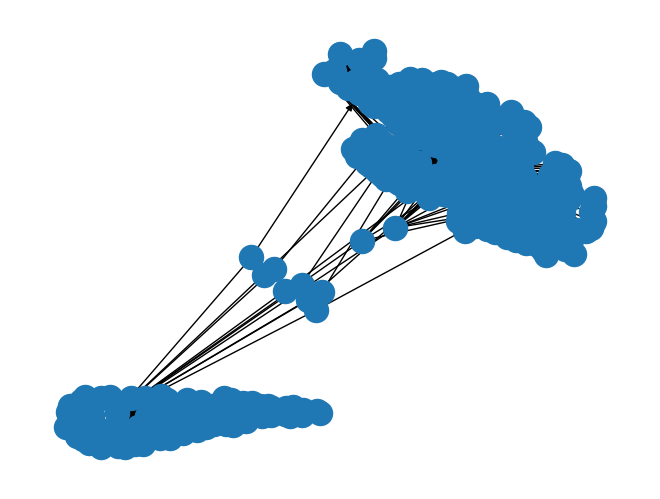

In [106]:
nx.draw(G)

In [107]:
from pyvis.network import Network

nt = Network('720px', '1280px')
nt.from_nx(G)
nt.repulsion()
# nt.toggle_physics(True)
nt.show('nx_bottomup.html', notebook=False)

nx_bottomup.html


In [108]:
# girvan newman algorithm
# it takes so long to run this, todo: use tqdm to display bar
communities = nx.community.girvan_newman(G)
list_of_communities = list(communities)

In [109]:
len(list_of_communities[1])

3

In [110]:
tmp = []
for st in list_of_communities[1]:
    tmp.append(list(st))

In [111]:
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']

for i, community in enumerate(tmp):
    for node in community:
        nt.get_node(node)['color'] = colors[i % len(colors)]

In [112]:
nt.show('nx_bottomup_girvan.html', notebook=False)

nx_bottomup_girvan.html


In [113]:
# DUMP
import pickle

with open('nxgraph.pickle', 'wb') as handle:
    pickle.dump(G, handle, -1)

with open('nxgraph.pickle', 'rb') as handle:
    new_G = pickle.load(handle)

In [115]:
from pyvis.network import Network

nt = Network('720px', '1280px')
nt.from_nx(new_G)
nt.repulsion()
# nt.toggle_physics(True)
nt.show('nx_pickle_bottomup.html', notebook=False)

nx_pickle_bottomup.html
